# Image Classification Model Deployment : Klasifikasi CT Scan Covid-19, Normal, CAP

# Data Preparation

## Import Library

In [1]:
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import pathlib
import numpy as np
import splitfolders
import tensorflow as tf
from tensorflow import keras
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152V2
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

## Download Dataset

In [3]:
!gdown 1dSTxJdZPLtBdMNYgddhh1mK7IfiHsMxb

Downloading...
From: https://drive.google.com/uc?id=1dSTxJdZPLtBdMNYgddhh1mK7IfiHsMxb
To: /content/large-covid19-ct-slice-dataset.zip
100% 2.21G/2.21G [00:16<00:00, 135MB/s]


In [4]:
!unzip '/content/large-covid19-ct-slice-dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: curated_data/curated_data/2COVID/P024_121.png  
  inflating: curated_data/curated_data/2COVID/P024_122.png  
  inflating: curated_data/curated_data/2COVID/P024_123.png  
  inflating: curated_data/curated_data/2COVID/P024_124.png  
  inflating: curated_data/curated_data/2COVID/P024_125.png  
  inflating: curated_data/curated_data/2COVID/P024_127.png  
  inflating: curated_data/curated_data/2COVID/P024_128.png  
  inflating: curated_data/curated_data/2COVID/P024_129.png  
  inflating: curated_data/curated_data/2COVID/P024_130.png  
  inflating: curated_data/curated_data/2COVID/P024_131.png  
  inflating: curated_data/curated_data/2COVID/P024_132.png  
  inflating: curated_data/curated_data/2COVID/P024_133.png  
  inflating: curated_data/curated_data/2COVID/P024_134.png  
  inflating: curated_data/curated_data/2COVID/P024_135.png  
  inflating: curated_data/curated_data/2COVID/P024_136.png  
  inflating: curated_data/curated_

In [5]:
base_dir = '/content/curated_data/curated_data'
os.listdir(base_dir)

['3CAP', '2COVID', '1NonCOVID']

In [6]:
noncovid_dir = os.path.join(base_dir, '1NonCOVID')
covid_dir = os.path.join(base_dir, '2COVID')
cap_dir = os.path.join(base_dir, '3CAP')

## Exploratory Data Analysis

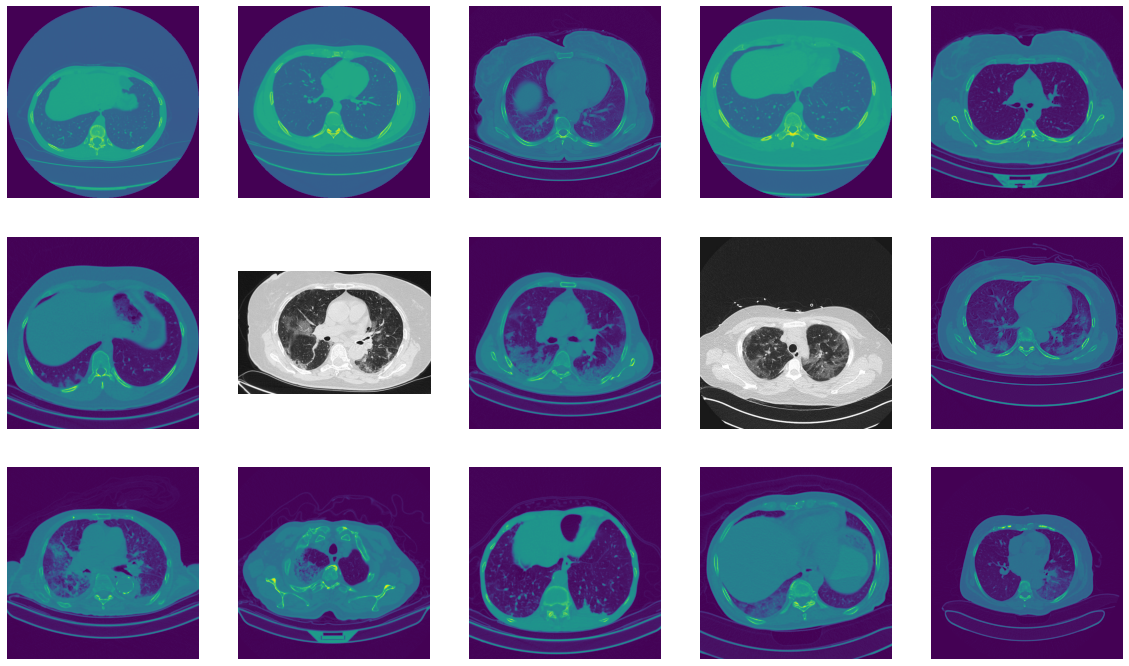

In [7]:
%matplotlib inline
files_noncovid = os.listdir(noncovid_dir)
files_covid = os.listdir(covid_dir)
files_cap = os.listdir(cap_dir)

nrows = 3
ncols = 5

pic_index = 0 

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
pic_index += 5

images_noncovid = [os.path.join(noncovid_dir, fname)
                         for fname in files_noncovid[pic_index - 5:pic_index]]
images_covid = [os.path.join(covid_dir, fname)
                         for fname in files_covid[pic_index - 5:pic_index]]
images_cap = [os.path.join(cap_dir, fname)
                         for fname in files_cap[pic_index - 5:pic_index]]

for i, img_path in enumerate(images_noncovid + images_covid + images_cap):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

# Data Preprocessing

## Split Data

In [8]:
splitfolders.ratio(base_dir, output = base_dir, seed = 1337, ratio = (.8, .2))

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

Copying files: 17104 files [00:08, 1940.95 files/s]


In [9]:
train_noncovid_dir, validation_noncovid_dir = train_test_split(os.listdir(noncovid_dir), test_size = 0.2, train_size = 0.8)
train_covid_dir, validation_covid_dir = train_test_split(os.listdir(covid_dir), test_size = 0.2, train_size = 0.8)
train_cap_dir, validation_cap_dir = train_test_split(os.listdir(cap_dir), test_size = 0.2, train_size = 0.8)

In [10]:
train_noncovid_dir = os.path.join(train_dir, '1NonCOVID')
train_covid_dir = os.path.join(train_dir, '2COVID')
train_cap_dir = os.path.join(train_dir, '3CAP')

validation_noncovid = os.path.join(validation_dir, '1NonCOVID')
validation_covid = os.path.join(validation_dir, '2COVID') 
validation_cap = os.path.join(validation_dir, '3CAP')

## Data Augmentation

In [11]:
train_dir = base_dir + "/train"
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    height_shift_range=0.2,
    width_shift_range=0.2,
    fill_mode='nearest')

validation_dir = base_dir + "/val"
validation_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_datagen.flow_from_directory(
  directory=train_dir,   
  target_size=(150,150), 
  class_mode='categorical',  
  shuffle=True,
  batch_size=64)

validation_generator = validation_datagen.flow_from_directory(
  directory=validation_dir,  
  target_size=(150,150),  
  class_mode='categorical',
  shuffle=True,
  batch_size=64)

Found 13682 images belonging to 3 classes.
Found 3422 images belonging to 3 classes.


# Data Modelling

## Model

In [13]:
model = tf.keras.models.Sequential([                             
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  
])

In [14]:
model.compile(loss ='categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

## Callback

In [15]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92):
      print("\nAkurasi telah mencapai > 92%!")
      self.model.stop_training = True
callbacks = myCallback()

## Fit

In [16]:
history = model.fit(
    train_generator,
    epochs=20,
    batch_size=64,
    callbacks = [callbacks],
    validation_data=validation_generator
)

Epoch 1/20
214/214 [==============================] - 173s 740ms/step - loss: 0.8089 - accuracy: 0.6404 - val_loss: 0.8440 - val_accuracy: 0.6847
Epoch 2/20
214/214 [==============================] - 152s 709ms/step - loss: 0.6716 - accuracy: 0.7075 - val_loss: 0.8277 - val_accuracy: 0.6885
Epoch 3/20
214/214 [==============================] - 151s 702ms/step - loss: 0.6015 - accuracy: 0.7405 - val_loss: 0.5784 - val_accuracy: 0.7478
Epoch 4/20
214/214 [==============================] - 151s 702ms/step - loss: 0.5614 - accuracy: 0.7668 - val_loss: 0.5147 - val_accuracy: 0.8022
Epoch 5/20
214/214 [==============================] - 151s 703ms/step - loss: 0.5174 - accuracy: 0.7859 - val_loss: 0.4526 - val_accuracy: 0.8217
Epoch 6/20
214/214 [==============================] - 151s 703ms/step - loss: 0.4966 - accuracy: 0.7973 - val_loss: 0.6826 - val_accuracy: 0.7680
Epoch 7/20
214/214 [==============================] - 151s 704ms/step - loss: 0.4872 - accuracy: 0.7986 - val_loss: 0.5801 -

## Visualization Model

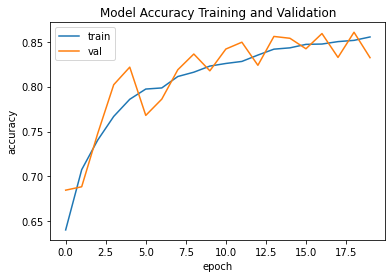

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Training and Validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

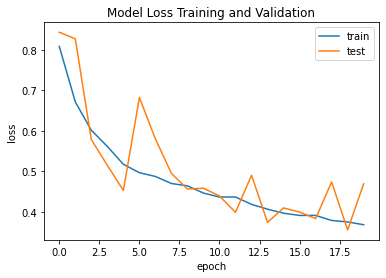

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Training and Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Predict Image

#### 1. Create Predict Function

In [22]:
def predict_image(image_upload, model = model):
  imge = image_upload
  imge_array = np.asarray(imge)
  imge_array = imge_array*(1/225)
  imge_input = tf.reshape(imge_array, shape = [1, 150, 150, 3])

  predict_array = model.predict(imge_input)[0]
  predict_kelas = np.argmax(model.predict(imge_input))

  if predict_kelas == 0:
      predict_item = 'Normal'
  elif predict_kelas == 1:
      predict_item = 'Covid-19'
  elif predict_kelas == 2:
      predict_item = 'CAP'
  else:
      predict_item = 'Not Normal, Covid-19, and CAP'

  return predict_item

In [23]:
def predict():
  uploaded = files.upload()

  for fn in uploaded.keys():
    path = fn
    img = tf.keras.utils.load_img(path, target_size=(150,150))
    imgplot = plt.imshow(img)
    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    img = np.vstack([x])

  kelas = predict_image(img)

  print('\n')
  plt.show()
  print('The model detected images as ' + kelas)

#### 2. Try Predict

Saving 13_Bjorke_1.png to 13_Bjorke_1.png
1/1 [==============================] - 0s 29ms/step




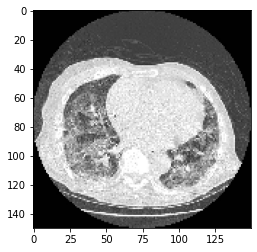

The model detected images as Covid-19


In [24]:
predict()

## Save Model

In [25]:
# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)
 
# Convert SavedModel menjadi model.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

338370020